## Setup

In [ ]:
%load_ext autoreload

%autoreload 2

In [ ]:
import random
import time
import warnings
from datetime import datetime

import torch

import numpy as np

import matplotlib.pyplot as plt
from scripts.differentiable_pfn_evaluation import eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from scripts.model_configs import *

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from priors.utils import plot_prior, plot_features
from priors.utils import uniform_int_sampler_f

from scripts.tabular_metrics import calculate_score_per_method, calculate_score
from scripts.tabular_evaluation import evaluate

from priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from scripts import tabular_metrics
from notebook_utils import *

In [ ]:
large_datasets = True
max_samples = 10000 if large_datasets else 5000
bptt = 10000 if large_datasets else 3000
suite='cc'

In [ ]:
device = 'cpu'
base_path = '.'
max_features = 100

In [ ]:
def print_models(model_string):
    print(model_string)

    for i in range(80):
        for e in range(50):
            exists = Path(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt')).is_file()
            if exists:
                print(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt'))
        print()

In [ ]:
def train_function(config_sample, i, add_name=''):
    start_time = time.time()
    N_epochs_to_save = 50
    
    def save_callback(model, epoch):
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0
        if ((time.time() - start_time) / (maximum_runtime * 60 / N_epochs_to_save)) > model.last_saved_epoch:
            print('Saving model..')
            config_sample['epoch_in_training'] = epoch
            save_model(model, base_path, f'models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{model.last_saved_epoch}.cpkt',
                           config_sample)
            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint
    
    model = get_model(config_sample
                      , device
                      , should_train=True
                      , verbose=1
                      , epoch_callback = save_callback)
    
    return

## Define prior settings

In [17]:
def reload_config(config_type='causal', task_type='multiclass', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'], config['differentiable'], config['flexible'] = 'prior_bag', True, True
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

## Visualize Prior samples

In [19]:
config, model_string = reload_config(longer=1)

config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

config['multiclass_type'] = 'rank'
del config['differentiable_hyperparameters']['multiclass_type']

config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = .2 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = False # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 8
config['batch_size'] = 8*config['aggregate_k_gradients']
config['num_steps'] = 1024//config['aggregate_k_gradients']
config['epochs'] = 400
config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

config_sample = evaluate_hypers(config)

Using style prior: True
MODEL BUILDER <module 'priors.differentiable_prior' from '/home/hollmann/TabPFN/priors/differentiable_prior.py'> <function get_model.<locals>.make_get_batch.<locals>.new_get_batch at 0x7f24bd339af0>
Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 33554432, 'get_batch_kwargs': {'batch_size': 1, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7f24bd493ee0>, 'seq_len_maximum': 1152, 'device': 'cpu:0', 'num_features': 100, 'hyperparameters': {'lr': 0.00011555441385381896, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 1152, 'eval_positions': [1094], 'seq_len_used': 50, 'sampling': 'normal', 'epochs': 400, 'num_steps': 33554432, 'verbose': True, 'mix_activations': False, 'pre_sample_causes': True, 'multiclass_type': 'rank', 'nan_prob_unknown_reason_reason_prior': 0.5, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0

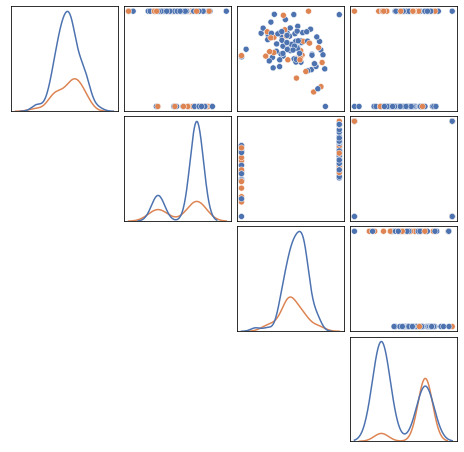

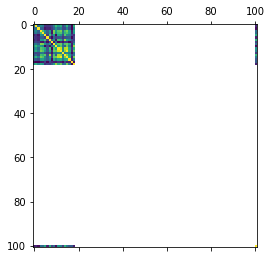

In [25]:
config_sample['batch_size'] = 4
model = get_model(config_sample, device, should_train=False, verbose=2) # , state_dict=model[2].state_dict()
(hp_embedding, data, _), targets, single_eval_pos = next(iter(model[3]))

from utils import normalize_data
fig = plt.figure(figsize=(8, 8))
N = 100
plot_features(data[0:N, 0, 0:4], targets[0:N, 0], fig=fig)

d = np.concatenate([data[:, 0, :].T, np.expand_dims(targets[:, 0], -1).T])
d[np.isnan(d)] = 0
c = np.corrcoef(d)
plt.matshow(np.abs(c), vmin=0, vmax=1)
plt.show()

## Training

In [ ]:
model = get_model(config_sample, device, should_train=True, verbose=0)